Joanna Kondylis

To use GPU acceleration with Google Colab, select 'GPU' in Edit > Notebook settings > Hardware accelerator.**bold text**

In [ ]:
import os
import time
import datetime
import random
import math

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import (DataLoader, Dataset)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [ ]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False


In [ ]:
# Check the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

In [ ]:
# this code cell contains functions related to the lab
# there should be NO need to modify anything within this cell

def get_network_complexity_info(activation_size, energy, latency):
    """
    Generate network complexity info
    """
    info = {}
    info['activation'] = activation_size
    info['energy'] = energy
    info['latency'] = latency
    return info

def get_lab_score(accuracy, network_complexity):
    """
    Calculates your lab score. We will compute your lab score seperately when grading.
    """
    error_rate = (1 - accuracy) * 100
    loss = error_rate / 12 + network_complexity['latency'] / 0.3
    
    if error_rate > 50:
        return (0, loss)
    elif network_complexity['activation'] > 1000000:
        return (0, loss)
    else:
        score = 0
        if network_complexity['energy'] > 2:
            score += 0
        elif network_complexity['energy'] > 1.5:
            score += 5
        elif network_complexity['energy'] > 1:
            score += 10
        elif network_complexity['energy'] > 0.5:
            score += 15
        else:
            score += 20
            
        if network_complexity['latency'] > 1:
            score += 0
        elif network_complexity['latency'] > 0.5:
            score += 5
        elif network_complexity['latency'] > 0.25:
            score += 10
        elif network_complexity['latency'] > 0.1:
            score += 15
        else:
            score += 20
            
        if error_rate < 20:
            score += 60
        elif error_rate < 30:
            score += 50
        elif error_rate < 40:
            score += 40
        else:
            score += 30
            
        return (score, loss)

In [ ]:
# other utility functions
def get_timestamp():
    return datetime.datetime.now().strftime("%m-%d-%Y %I-%M%p")

## Load the dataset

In [ ]:
def load_data(batch_size) :
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                          std=(0.247, 0.243, 0.261))
        ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    train_size, val_size = (len(trainset)-10000), 10000
    train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
        
    dataloaders = {}
    dataloaders['train'] = trainloader
    dataloaders['val'] = validloader
    dataloaders['test'] = testloader
    
    return dataloaders

In [ ]:
batch_size = 64
dataloaders = load_data(batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch Image Size torch.Size([64, 3, 32, 32])


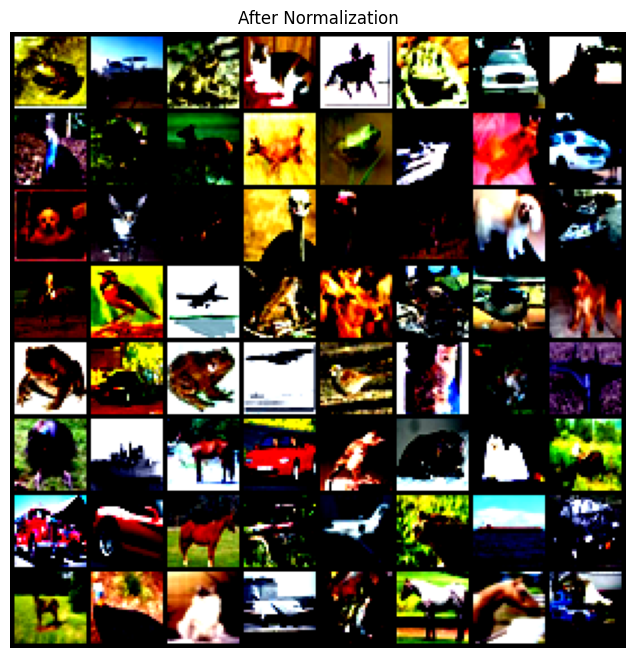

In [ ]:
for images, _ in dataloaders['train']:
    print('Batch Image Size', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute((1, 2, 0)))
    plt.title("After Normalization")
    break


## Network Definition

You will need to use a better network architecture here. Once finished, copy the network definition to `network-profile.ipynb` and run the energy/latency estimation, before generating the submission file (below).

In [ ]:
# define your own model [TODO]
# HINT : You might want to consider a network using depth-wise convolution and residual connection!

class Block(nn.Module):
    """
    3-D Deep Learning Approach for Remote Sensing Image Classification
    Amina Ben Hamida, Alexandre Benoit, Patrick Lambert, Chokri Ben Amar
    IEEE TGRS, 2018
    https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8344565
    """
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
            init.kaiming_normal_(m.weight)
            init.zeros_(m.bias)

    def __init__(self, input_channels, n_classes, patch_size=5, dilation=1):
        super(HamidaEtAl, self).__init__()
        # The first layer is a (3,3,3) kernel sized Conv characterized
        # by a stride equal to 1 and number of neurons equal to 20
        self.patch_size = patch_size
        self.input_channels = input_channels
        dilation = (dilation, 1, 1)

        if patch_size == 3:
            self.conv1 = nn.Conv3d(
                1, 20, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=1)
        else:
            self.conv1 = nn.Conv3d(
                1, 20, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=0)
        # Next pooling is applied using a layer identical to the previous one
        # with the difference of a 1D kernel size (1,1,3) and a larger stride
        # equal to 2 in order to reduce the spectral dimension
        self.pool1 = nn.Conv3d(
            20, 20, (3, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))
        # Then, a duplicate of the first and second layers is created with
        # 35 hidden neurons per layer.
        self.conv2 = nn.Conv3d(
            20, 35, (3, 3, 3), dilation=dilation, stride=(1, 1, 1), padding=(1, 0, 0))
        self.pool2 = nn.Conv3d(
            35, 35, (3, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))
        # Finally, the 1D spatial dimension is progressively reduced
        # thanks to the use of two Conv layers, 35 neurons each,
        # with respective kernel sizes of (1,1,3) and (1,1,2) and strides
        # respectively equal to (1,1,1) and (1,1,2)
        self.conv3 = nn.Conv3d(
            35, 35, (3, 1, 1), dilation=dilation, stride=(1, 1, 1), padding=(1, 0, 0))
        self.conv4 = nn.Conv3d(
            35, 35, (2, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))

        #self.dropout = nn.Dropout(p=0.5)

        self.features_size = self._get_final_flattened_size()
        # The architecture ends with a fully connected layer where the number
        # of neurons is equal to the number of input classes.
        self.fc = nn.Linear(self.features_size, n_classes)

        self.apply(self.weight_init)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, 1, self.input_channels,
                             self.patch_size, self.patch_size))
            x = self.pool1(self.conv1(x))
            x = self.pool2(self.conv2(x))
            x = self.conv3(x)
            x = self.conv4(x)
            _, t, c, w, h = x.size()
        return t * c * w * h

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.features_size)
        #x = self.dropout(x)
        x = self.fc(x)
        return x


class Net(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 2), # Lowered the expansion size from 6 -> 5 ; from mobilenet v2 changed it to 2
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1), 
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # self.activation = nn.ReLU6(inplace = True)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False) # Changed this stride from 2 -> 1 ; can also change the 32 channels to 16
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 640, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(640)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.d2 = nn.Dropout2d(0.15) # Current best 74% at 0.15
        self.linear = nn.Linear(640, num_classes) # From 1280
    
    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.d2(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## Training

In [ ]:
# instantiate model
model = Net()
model = model.to(device)

In [ ]:
# load old model weights if you wish to continue traning from an old model
# past_train_weights = os.path.join("./", "[TODO]"))
# model.load_state_dict(torch.load(past_train_weights))

In [ ]:
# setup loss function and optimization
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# [TODO] change parameters of SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) 

In [ ]:
# train network
# [TODO] Change #epochs to train (Should not exceed 30)
num_epochs = 10 # <30

train_loss_log = []
train_acc_log = []
val_loss_log = []
val_acc_log = []

for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    print("-" * 10)
    
    # training loop
    print("Training")
    model.train()
        
    running_loss = 0.0
    running_correct = 0
    running_count = 0
    
    pbar = tqdm(dataloaders['train'])
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get model outputs and calculate loss
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # compute predictions
        _, preds = torch.max(outputs, dim=1)
        correct = torch.sum(preds == labels).item()
        
        # calculate metrics
        running_loss += loss.detach().item() * inputs.size(0)
        running_correct += correct
        running_count += inputs.size(0)
        avg_loss = running_loss / running_count
        avg_acc = running_correct / running_count
        pbar.set_description("Avg. Loss: {:.4f}, Avg. Acc: {:.4f}".format(avg_loss, avg_acc))
    
    # log metrics
    train_loss_log.append(avg_loss)
    train_acc_log.append(avg_acc)
    pbar.close()
    
    # validation loop
    print("Validation")
    model.eval()
    
    running_loss = 0.0
    running_correct = 0
    running_count = 0
    
    pbar = tqdm(dataloaders['val'])
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # get model outputs and calculate loss
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # compute predictions
        _, preds = torch.max(outputs, dim=1)
        correct = torch.sum(preds == labels).item()
        
        # calculate metrics
        running_loss += loss.detach().item() * inputs.size(0)
        running_correct += correct
        running_count += inputs.size(0)
        avg_loss = running_loss / running_count
        avg_acc = running_correct / running_count
        pbar.set_description("Avg. Loss: {:.4f}, Avg. Acc: {:.4f}".format(avg_loss, avg_acc))
    
    # log metrics
    val_loss_log.append(avg_loss)
    val_acc_log.append(avg_acc)
    pbar.close()

Epoch 1/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

## Evaluation

Training metrics

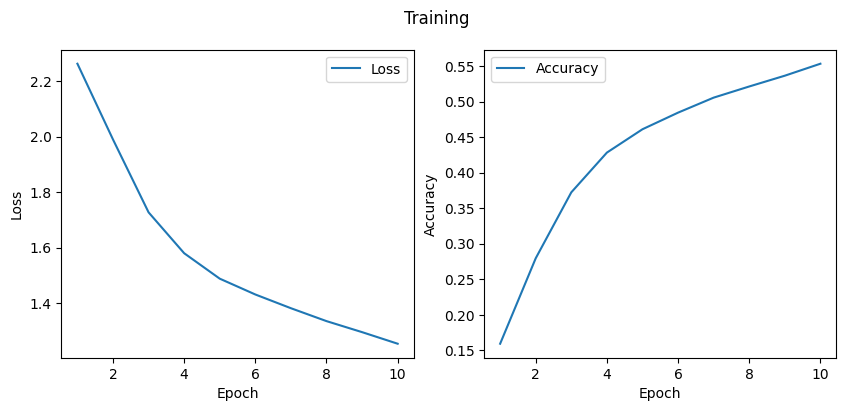

In [ ]:
train_epochs = np.arange(len(train_loss_log)) + 1

fig = plt.figure(figsize=(10, 4))
fig.suptitle("Training")

ax = fig.add_subplot(1, 2, 1)
ax.plot(train_epochs, train_loss_log, label='Loss')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_epochs, train_acc_log, label='Accuracy')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

fig.show()

Testing metrics

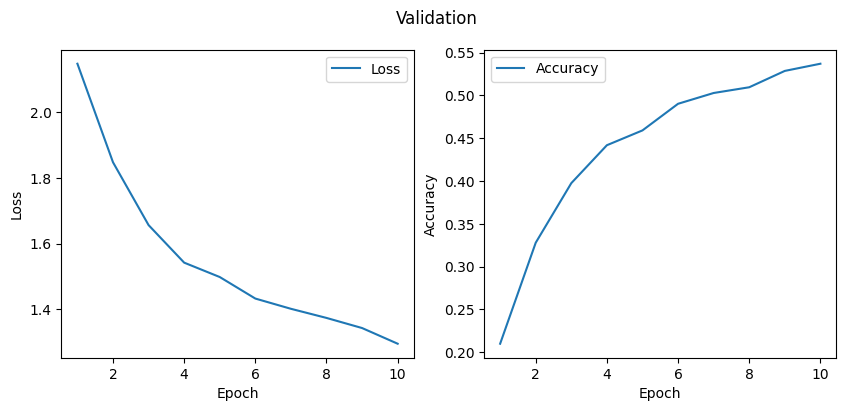

In [ ]:
val_epochs = np.arange(len(val_loss_log)) + 1

fig = plt.figure(figsize=(10, 4))
fig.suptitle("Validation")

ax = fig.add_subplot(1, 2, 1)
ax.plot(val_epochs, val_loss_log, label='Loss')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax = fig.add_subplot(1, 2, 2)
ax.plot(val_epochs, val_acc_log, label='Accuracy')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

fig.show()

In [ ]:
# test loop
model.eval()

running_loss = 0.0
running_correct = 0
running_count = 0

pbar = tqdm(dataloaders['test'])
for inputs, labels in pbar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # get model outputs and calculate loss
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
    # compute predictions
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    
    # calculate metrics
    running_loss += loss.detach().item() * inputs.size(0)
    running_correct += correct
    running_count += inputs.size(0)
    avg_loss = running_loss / running_count
    avg_acc = running_correct / running_count
    pbar.set_description("Avg. Loss: {:.4f}, Avg. Acc: {:.4f}".format(avg_loss, avg_acc))

test_acc_final = avg_acc

  0%|          | 0/157 [00:00<?, ?it/s]

Final performance

In [ ]:
train_acc_final = train_acc_log[-1]
val_acc_final = val_acc_log[-1]
print("Final Training Accuracy: {}%".format(train_acc_final * 100))
print("Final Validation Accuracy: {}%".format(val_acc_final * 100))
print("Final Testing Accuracy: {}%".format(test_acc_final * 100))

Final Training Accuracy: 55.3225%
Final Validation Accuracy: 53.7%
Final Testing Accuracy: 54.55%


## Save model

In [ ]:
model_fname = os.path.join("./", "Model Parameters {}".format(get_timestamp()))
torch.save(model.state_dict(), model_fname)

In [ ]:
if COLAB:
    from google.colab import files
    files.download(model_fname)

## Estimate assignment grade on validation set

Run the network profiler in `network-profile.ipynb` using your model description. Then copy your result into the cell below. Please check the unit conversion, and round the value to four decimal places.

In [ ]:
network_complexity = get_network_complexity_info(
    activation_size=114688.0, # activation size in Byte [TODO]
    energy=0.49528000, # estimated energy in mJ [TODO]
    latency=0.03289200) # number of cycles in Million (1e6) [TODO]

In [ ]:
final_score = get_lab_score(test_acc_final, network_complexity)
print("Final Score: {}".format(final_score))

Final Score: (70, 3.86239)
